Please read the assignment description document.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports: No other imports allowed

In [2]:
import numpy as np #No using automatic differentiation allowed from here!
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import sklearn.metrics as metrics

## Class template

In [3]:
def linearActivate(X):
    return X

def reluActivate(X):
    return np.maximum(0, X)

def softmaxActivate(X):
    expval = np.exp(X - np.max(X, axis=0, keepdims=True))
    return expval / np.sum(expval, axis=0, keepdims=True)

def linearActivateGrad(X):
    return 1

def reluActivateGrad(X):
    ar = X
    ar[ar >= 0] = 1
    ar[ar < 0] = 0
    return ar

def softmaxActivateGrad(X):
    val = softmaxActivate(X)
    return val * (1-val)
    

class NeuralNetworkClassifier: 
    
    def __init__(self, layers): 
        #### CHANGE THE CODE BELOW  
        
        # The number of layers, including the input layer
        self.num_layers = len(layers)
        
        # Information about each layer (like the size, activation function etc)
        self.linfo = {}
        
        # For each layers, give the info, following the convention that layer 0 is the input layer
        for l in range(0, self.num_layers):
            
            self.linfo[l] = list(layers[l])
            if(self.linfo[l][1] == 'linear'):
                self.linfo[l].append(linearActivate)
                self.linfo[l].append(linearActivateGrad)
                
            elif(self.linfo[l][1] == 'relu'):
                self.linfo[l].append(reluActivate)
                self.linfo[l].append(reluActivateGrad)
                
            else:
                self.linfo[l].append(softmaxActivate)
                self.linfo[l].append(softmaxActivateGrad)
                
            
        # Parameters for each layer
        self.weights = {}
        self.bias = {}
        
        # Randomly initializing the parameters for the layers (except the input one) 
        for l in range(1, self.num_layers):
            div = self.linfo[l-1][0] + self.linfo[l][0]
            self.weights[l] = np.random.randn(self.linfo[l][0], self.linfo[l-1][0])/np.sqrt(div)
            self.bias[l] = np.random.randn(self.linfo[l][0], 1)/np.sqrt(div)
        
        #### CHANGE THE CODE ABOVE
        
        
    def predict(self, X): 
        #### CHANGE THE CODE BELOW 

        Z = {}
        A = {}
        cura = X.T
        
        for l in range(1, self.num_layers):
            Z[l] = (self.weights[l] @ cura) + self.bias[l]
            activation_fun = self.linfo[l][2]
            A[l] = activation_fun(Z[l])
            cura = A[l]
        
        return cura.T
        #### CHANGE THE CODE ABOVE
        
    def fit_once(self, X, y, alpha=0.001): 
        #### CHANGE THE CODE BELOW
        
        y_d = np.zeros((len(y), self.linfo[len(self.linfo)-1][0]))
        for i in range(len(y)):
            y_d[i][y[i]] = 1
        y_d = y_d.T
          
        Z = {}
        A = {}
        Z[0] = X.T
        A[0] = X.T
        for l in range(1, self.num_layers):
            Z[l] = (self.weights[l] @ A[l-1]) + self.bias[l]
            activation_fun = self.linfo[l][2]
            A[l] = activation_fun(Z[l])
        
        dZ = {}
        dW = {}
        db = {}
        m = X.shape[0]
        dZ[self.num_layers-1] = A[self.num_layers-1] - y_d
        dW[self.num_layers-1] = (1/m) * (dZ[self.num_layers-1] @ A[self.num_layers-2].T)
        db[self.num_layers-1] = (1/m) * np.sum(dZ[self.num_layers-1], axis=1, keepdims=True)
        
        
        for l in range(self.num_layers-2, 0, -1):
            activationGrad = self.linfo[l][3]
            dZ[l] = (self.weights[l+1].T @ dZ[l+1]) * activationGrad(Z[l])
            dW[l] = (1/m) * (dZ[l] @ A[l-1].T)
            db[l] = (1/m) * np.sum(dZ[l], axis=1, keepdims=True)
        
        
        for l in range(1, self.num_layers):
            assert(self.weights[l].shape == dW[l].shape)
            self.weights[l] -= alpha*dW[l]
            assert(self.bias[l].shape == db[l].shape)
            self.bias[l] -= alpha*db[l]
        
        #### CHANGE THE CODE ABOVE
        
        
    def categorical_cross_entropy_loss(self, y, yhat):
      
        #### CHANGE THE CODE BELOW
        
        sh = (len(y), self.linfo[len(self.linfo)-1][0])
        y_d = np.zeros(sh)
        for i in range(len(y)):
            y_d[i][y[i]] = 1
            
        yhat = np.clip(yhat, 1e-7, 1-1e-7)
        logs = -np.log(np.sum(y_d * yhat, axis=1)) 
        return logs.mean()
    
        #### CHANGE THE CODE ABOVE
        


# Example main code

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment3/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment3/test.csv')
sample_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment3/sample_submission.csv')

In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
sample_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [8]:
X = train_df.iloc[:, 1:].to_numpy()
y = train_df['label'].to_numpy()

In [9]:
X = X/255

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20, random_state=3)

In [11]:
model = NeuralNetworkClassifier([(X_train.shape[1], "relu"), (256, "relu"), (256, "relu"), (10, "softmax")])

In [12]:
train_losses = [] 
test_losses = []
NUM_ITERS = 1000

finy_test = y_test
finyhat_test = 0

for _ in range(NUM_ITERS):
    yhat = model.predict(X_train)
    train_loss = model.categorical_cross_entropy_loss(y_train, yhat)
    yhat_test = model.predict(X_test)
    test_loss = model.categorical_cross_entropy_loss(y_test, yhat_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    model.fit_once(X_train, y_train, 0.1)
    if(len(test_losses) >= 6 and (test_losses[-1] > test_losses[-6])):
      # print("Test loss[-1]", test_losses[-1], " Test loss[-6]", test_losses[-6])
      print("Early Stopping")
      break

    print("Accuracy : " + str(1 - (yhat_test.argmax(axis=1) != y_test).sum()/len(y_test)) )
    print(_, "Train_loss = " + str(train_loss) + "     Test_loss = " + str(test_loss))
    print("")
    
    if( _ == NUM_ITERS-1):
       finyhat_test = yhat_test

Accuracy : 0.12095238095238092
0 Train_loss = 2.298612941281724     Test_loss = 2.298608729982354

Accuracy : 0.16607142857142854
1 Train_loss = 2.281612560365073     Test_loss = 2.2818273844755232

Accuracy : 0.21499999999999997
2 Train_loss = 2.2646867631846663     Test_loss = 2.2651038610719936

Accuracy : 0.27202380952380956
3 Train_loss = 2.2476404414864586     Test_loss = 2.2482645996513684

Accuracy : 0.3391666666666666
4 Train_loss = 2.2302553745421743     Test_loss = 2.2310934273028415

Accuracy : 0.39642857142857146
5 Train_loss = 2.212380502972697     Test_loss = 2.2134481113452686

Accuracy : 0.44666666666666666
6 Train_loss = 2.193852108631956     Test_loss = 2.195136823324702

Accuracy : 0.4848809523809524
7 Train_loss = 2.174536020753785     Test_loss = 2.176029188086015

Accuracy : 0.5175000000000001
8 Train_loss = 2.154310920423274     Test_loss = 2.1560059951025567

Accuracy : 0.5472619047619047
9 Train_loss = 2.133062982655517     Test_loss = 2.134953541676623

Accur

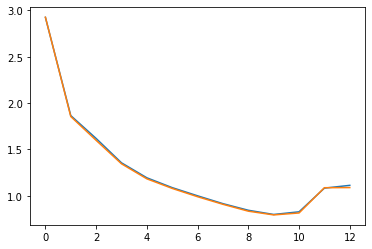

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)

In [ ]:
finyhat_test.argmax(axis=1)

array([4, 4, 6, ..., 7, 1, 5])

In [ ]:
y_test

array([4, 4, 6, ..., 7, 1, 5])

In [ ]:
(finyhat_test.argmax(axis=1) != y_test).sum()/len(y_test)

0.07119047619047619



### Making submission

In [ ]:
X_te = test_df.to_numpy()
X_te = X_te/255

In [ ]:
y_te = model.predict(X_te).argmax(axis=1)

In [ ]:
y_te

array([2, 0, 9, ..., 3, 9, 2])

In [ ]:
sample_df['Label'] = y_te

In [ ]:
sample_df.to_csv("NN_twolayer_normal_128_256_1.csv", index=False)

## Getting some data

This is random data. DO NOT USE THIS. This is just to show you what the function calls would be like.

In [ ]:
NUM_ROWS = 10000
NUM_COLUMNS_X = 200 
NUM_CLASSES = 5
X = np.random.uniform(size=(NUM_ROWS,NUM_COLUMNS_X))
y = np.random.randint(size=(NUM_ROWS,),low=0,high=NUM_CLASSES)

In [ ]:
model = NeuralNetworkClassifier([(NUM_COLUMNS_X, "relu"), (200, "relu"), (NUM_CLASSES, "softmax")])

In [ ]:
yd = np.zeros((len(y), NUM_CLASSES))
for i in range(len(y)):
    yd[i][y[i]-1] = 1

In [ ]:
model.predict(X)

array([[6.51735571e-04, 9.88383807e-01, 6.17773969e-03, 4.46074257e-04,
        4.34064348e-03],
       [1.03730682e-03, 9.84018546e-01, 8.62198428e-03, 6.68718651e-04,
        5.65344466e-03],
       [1.47501066e-03, 9.80120147e-01, 1.01080563e-02, 9.41745652e-04,
        7.35504012e-03],
       ...,
       [1.07377647e-03, 9.83331962e-01, 8.94290440e-03, 7.64428204e-04,
        5.88692908e-03],
       [1.21479588e-03, 9.81413921e-01, 9.76396501e-03, 8.35904428e-04,
        6.77141363e-03],
       [1.13575878e-03, 9.83710729e-01, 8.39080987e-03, 7.56295056e-04,
        6.00640749e-03]])

In [ ]:
model.categorical_cross_entropy_loss(y, model.predict(X))

4.793445531816353

In [ ]:
losses = [] 
NUM_ITERS = 100
for _ in range(NUM_ITERS):
    yhat = model.predict(X)
    loss = model.categorical_cross_entropy_loss(y, yhat)
    losses.append(loss)
    model.fit_once(X, y)


In [ ]:
losses

[4.793445531816353,
 4.401753425856968,
 4.021828510590914,
 3.6597644849216624,
 3.3234590729271893,
 3.0216763923272665,
 2.761871481079625,
 2.5474775802452263,
 2.376481663143961,
 2.242523181984943,
 2.1375644686610658,
 2.054181558787989,
 1.9865785440529005,
 1.9306287590757683,
 1.8835204183743917,
 1.8433588423018594,
 1.8088501501263066,
 1.7790810848963745,
 1.7533755101472572,
 1.7312045484170067,
 1.7121321142377146,
 1.6957830252151016,
 1.6818250946759143,
 1.6699595640209275,
 1.6599162418531153,
 1.651451074887023,
 1.6443447882988351,
 1.6384018361938462,
 1.633449288226895,
 1.6293355118664818,
 1.6259286400297552,
 1.623114876944084,
 1.6207967172112359,
 1.6188911522196578,
 1.6173279260877305,
 1.6160478874546296,
 1.6150014677118636,
 1.6141473026612811,
 1.6134510038086969,
 1.612884077567911,
 1.6124229852243417,
 1.612048333127781,
 1.6117441807762636,
 1.6114974537929225,
 1.6112974489317355,
 1.6111354188981633,
 1.6110042257268051,
 1.6108980525683105,
 1.6

In [ ]:
q = np.array([[1, -1, 2], [1, 2, 3]])

In [ ]:
q + np.array([[1], [2]])

array([[2, 0, 3],
       [3, 4, 5]])

In [ ]:
 np.random.uniform(low=0, high=0.1, size=(4, 1))

array([[0.07382656],
       [0.07878063],
       [0.02466814],
       [0.08475965]])

In [ ]:
q = np.array([[1, -1, 2], [1, 2, 3]])
np.exp(q) / np.tile(np.exp(q).sum(axis=1), (3, 1)).T


array([[0.25949646, 0.03511903, 0.70538451],
       [0.09003057, 0.24472847, 0.66524096]])

In [ ]:
softmaxActivate(q)

array([[0.25949646, 0.03511903, 0.70538451],
       [0.09003057, 0.24472847, 0.66524096]])

In [ ]:
l = [softmaxActivate]

In [ ]:
l[0](q)

array([[0.25949646, 0.03511903, 0.70538451],
       [0.09003057, 0.24472847, 0.66524096]])

In [ ]:
np.exp(q)

array([[ 2.71828183,  0.36787944,  7.3890561 ],
       [ 2.71828183,  7.3890561 , 20.08553692]])

In [ ]:
r = np.array([-1,5,6])

In [ ]:
r[r<0] = 0
r[r>0] = 1

In [ ]:
r

array([0, 1, 1])